# Time series classification with CNN

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_time_series_classification.ipynb)

In this tutorial, we're going to perform time series classification with a Convolutional Neural Network.
We will use the FordA dataset from the [UCR archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/),
which contains measurements of engine noise captured by a motor sensor.

We need to assess if an engine is malfunctioning based on the recorded noises it generates.
Each sample comprises of noise measurements across time, together with a "yes/no" label,
so this is a binary classification problem.

Although convolution models are mainly associated with image processing, they are also useful
for time series data because they can extract temporal structures.

## Tools overview and setup

Here's a list of key packages that belong to the JAX AI stack required for this tutorial:

- [JAX](https://github.com/jax-ml/jax) for array computations.
- [Flax](https://github.com/google/flax) for constructing neural networks.
- [Optax](https://github.com/google-deepmind/optax) for gradient processing and optimization.
- [Grain](https://github.com/google/grain/) to define data sources.
- [tqdm](https://tqdm.github.io/) for a progress bar to monitor the training progress.

We'll start by installing and importing these packages.

In [1]:
# Required packages
# !pip install -U jax flax optax
# !pip install -U grain tqdm requests matplotlib

In [2]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax

import numpy as np
import matplotlib.pyplot as plt
import grain.python as grain
import tqdm

## Load the dataset

We load dataset files into NumPy arrays, add singleton dimension to take convolution features
into account, and change `-1` label to `0` (so that the expected values are `0` and `1`):

In [3]:
def prepare_ucr_dataset() -> tuple:
    root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

    train_data = np.loadtxt(root_url + "FordA_TRAIN.tsv", delimiter="\t")
    x_train, y_train = train_data[:, 1:], train_data[:, 0].astype(int)

    test_data = np.loadtxt(root_url + "FordA_TEST.tsv", delimiter="\t")
    x_test, y_test = test_data[:, 1:], test_data[:, 0].astype(int)

    x_train = x_train.reshape((*x_train.shape, 1))
    x_test = x_test.reshape((*x_test.shape, 1))

    rng = np.random.RandomState(113)
    indices = rng.permutation(len(x_train))
    x_train = x_train[indices]
    y_train = y_train[indices]

    y_train[y_train == -1] = 0
    y_test[y_test == -1] = 0

    return (x_train, y_train), (x_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = prepare_ucr_dataset()

Let's visualize example samples from each class.

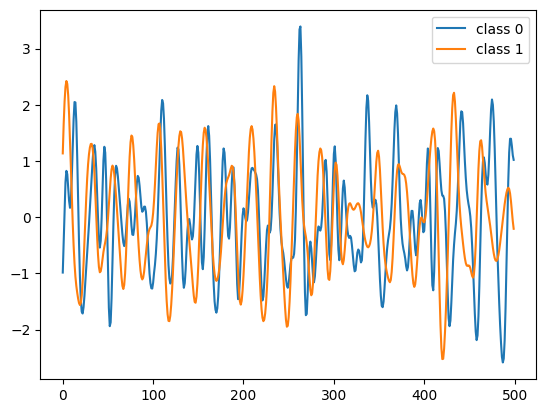

In [5]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend()
plt.show()

### Create a Data Loader using Grain

For handling input data we're going to use Grain, a pure Python package developed for JAX and
Flax models.

Grain follows the source-sampler-loader paradigm. Grain supports custom setups where data sources
might come in different forms, but they all need to implement the `grain.RandomAccessDataSource`
interface. See [PyGrain Data Sources](https://github.com/google/grain/blob/main/docs/source/data_sources.md)
for more details.

Our dataset is comprised of relatively small NumPy arrays so our `DataSource` is uncomplicated:

In [6]:
class DataSource(grain.RandomAccessDataSource):
    def __init__(self, x, y):
        self._x = x
        self._y = y

    def __getitem__(self, idx):
        return {"measurement": self._x[idx], "label": self._y[idx]}

    def __len__(self):
        return len(self._x)

In [7]:
train_source = DataSource(x_train, y_train)
test_source = DataSource(x_test, y_test)

Samplers determine the order in which records are processed, and we'll use the
[`IndexSmapler`](https://github.com/google/grain/blob/main/docs/source/data_loader/samplers.md#index-sampler)
recommended by Grain.

Finally, we'll create `DataLoader`s that handle orchestration of loading.
We'll leverage Grain's multiprocessing capabilities to scale processing up to 4 workers.

In [8]:
seed = 12
train_batch_size = 128
test_batch_size = 2 * train_batch_size

train_sampler = grain.IndexSampler(
    len(train_source),
    shuffle=True,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)

test_sampler = grain.IndexSampler(
    len(test_source),
    shuffle=False,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)


train_loader = grain.DataLoader(
    data_source=train_source,
    sampler=train_sampler,  # Sampler to determine how to access the data
    worker_count=4,         # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,   # Count of output batches to produce in advance per worker
    operations=[
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

test_loader = grain.DataLoader(
    data_source=test_source,
    sampler=test_sampler,  # Sampler to determine how to access the data
    worker_count=4,        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,  # Count of output batches to produce in advance per worker
    operations=[
        grain.Batch(test_batch_size),
    ]
)

## Define the Model

Let's now construct the Convolutional Neural Network with Flax by subclassing `nnx.Module`.
You can learn more about the [Flax NNX module system in the Flax documentation](https://flax.readthedocs.io/en/latest/nnx_basics.html#the-flax-nnx-module-system).

Let's have three convolution and dense layers, and use ReLU activation function for middle
layers and softmax in the final layer for binary classification output.

In [9]:
class MyModel(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.conv_1 = nnx.Conv(
            in_features=1, out_features=64, kernel_size=3, padding="SAME", rngs=rngs
        )
        self.layer_norm_1 = nnx.LayerNorm(num_features=64, epsilon=0.001, rngs=rngs)

        self.conv_2 = nnx.Conv(
            in_features=64, out_features=64, kernel_size=3, padding="SAME", rngs=rngs
        )
        self.layer_norm_2 = nnx.LayerNorm(num_features=64, epsilon=0.001, rngs=rngs)

        self.conv_3 = nnx.Conv(
            in_features=64, out_features=64, kernel_size=3, padding="SAME", rngs=rngs
        )
        self.layer_norm_3 = nnx.LayerNorm(num_features=64, epsilon=0.001, rngs=rngs)

        self.dense_1 = nnx.Linear(in_features=64, out_features=2, rngs=rngs)

    def __call__(self, x: jax.Array):
        x = self.conv_1(x)
        x = self.layer_norm_1(x)
        x = jax.nn.relu(x)

        x = self.conv_2(x)
        x = self.layer_norm_2(x)
        x = jax.nn.relu(x)

        x = self.conv_3(x)
        x = self.layer_norm_3(x)
        x = jax.nn.relu(x)

        x = jnp.mean(x, axis=(1,))  # global average pooling
        x = self.dense_1(x)
        x = jax.nn.softmax(x)
        return x

In [10]:
model = MyModel(rngs=nnx.Rngs(0))
nnx.display(model)

MyModel(
  conv_1=Conv(
    kernel_shape=(3, 1, 64),
    kernel=Param(
      value=Array(shape=(3, 1, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=1,
    out_features=64,
    kernel_size=(3,),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7fec9a939bd0>,
    bias_init=<function zeros at 0x7fec9b3cecb0>,
    conv_general_dilated=<function conv_general_dilated at 0x7fec9b897be0>
  ),
  layer_norm_1=LayerNorm(
    scale=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    num_features=64,
    epsilon=0.001,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    use_bias=True,
    use_scale=True,
    bi

## Train the Model

To train our Flax model we need to construct an `nnx.Optimizer` object with our model and
a selected optimization algorithm. The optimizer object manages the model’s parameters and
applies gradients during training.

We're going to use [Adam optimizer](https://optax.readthedocs.io/en/latest/api/optimizers.html#adam),
a popular choice for Deep Learning models. We'll use it through
[Optax](https://optax.readthedocs.io/en/latest/index.html), an optimization library developed for JAX.

In [11]:
num_epochs = 300
learning_rate = 0.0005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adam(learning_rate, momentum))

We'll define a loss and logits computation function using Optax's
[`losses.softmax_cross_entropy_with_integer_labels`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.losses.softmax_cross_entropy_with_integer_labels).

In [12]:
def compute_losses_and_logits(model: nnx.Module, batch_tokens: jax.Array, labels: jax.Array):
    logits = model(batch_tokens)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels
    ).mean()
    return loss, logits

We'll now define the training and evaluation step functions. The loss and logits from both
functions will be used for calculating accuracy metrics.

For training, we'll use `nnx.value_and_grad` to compute the gradients, and then update
the model’s parameters using our optimizer.

Notice the use of [`nnx.jit`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.jit). This sets up the functions for just-in-time (JIT) compilation with [XLA](https://openxla.org/xla)
for performant execution across different hardware accelerators like GPUs and TPUs.

In [13]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, jax.Array]
):
    batch_tokens = jnp.array(batch["measurement"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch_tokens, labels)

    optimizer.update(grads)  # In-place updates.

    return loss

@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, jax.Array], eval_metrics: nnx.MultiMetric
):
    batch_tokens = jnp.array(batch["measurement"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)
    loss, logits = compute_losses_and_logits(model, batch_tokens, labels)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

In [14]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

We can now train the CNN model. We'll evaluate the model’s performance on the test set
after each epoch, and print the metrics: total loss and accuracy.

In [15]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(x_train) // train_batch_size

def train_one_epoch(epoch: int):
    model.train()
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        miniters=10,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)

def evaluate_model(epoch: int):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()

    eval_metrics.reset()  # Reset the eval metrics
    for test_batch in test_loader:
        eval_step(model, test_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    if epoch % 10 == 0:
        print(f"[test] epoch: {epoch + 1}/{num_epochs}")
        print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
        print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

In [16]:
%%time
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/300, [28/28], loss=0.684 [00:05<00:00]


[test] epoch: 1/300
- total loss: 0.6887
- Accuracy: 0.5159


[train] epoch: 1/300, [28/28], loss=0.676 [00:03<00:00]
[train] epoch: 2/300, [28/28], loss=0.663 [00:03<00:00]
[train] epoch: 3/300, [28/28], loss=0.655 [00:03<00:00]
[train] epoch: 4/300, [28/28], loss=0.654 [00:03<00:00]
[train] epoch: 5/300, [28/28], loss=0.649 [00:03<00:00]
[train] epoch: 6/300, [28/28], loss=0.651 [00:03<00:00]
[train] epoch: 7/300, [28/28], loss=0.646 [00:03<00:00]
[train] epoch: 8/300, [28/28], loss=0.62 [00:03<00:00] 
[train] epoch: 9/300, [28/28], loss=0.632 [00:03<00:00]
[train] epoch: 10/300, [28/28], loss=0.606 [00:03<00:00]


[test] epoch: 11/300
- total loss: 0.6179
- Accuracy: 0.7068


[train] epoch: 11/300, [28/28], loss=0.6 [00:03<00:00]  
[train] epoch: 12/300, [28/28], loss=0.604 [00:03<00:00]
[train] epoch: 13/300, [28/28], loss=0.587 [00:03<00:00]
[train] epoch: 14/300, [28/28], loss=0.588 [00:03<00:00]
[train] epoch: 15/300, [28/28], loss=0.583 [00:03<00:00]
[train] epoch: 16/300, [28/28], loss=0.578 [00:03<00:00]
[train] epoch: 17/300, [28/28], loss=0.578 [00:03<00:00]
[train] epoch: 18/300, [28/28], loss=0.575 [00:03<00:00]
[train] epoch: 19/300, [28/28], loss=0.573 [00:03<00:00]
[train] epoch: 20/300, [28/28], loss=0.57 [00:03<00:00] 


[test] epoch: 21/300
- total loss: 0.5673
- Accuracy: 0.7848


[train] epoch: 21/300, [28/28], loss=0.567 [00:03<00:00]
[train] epoch: 22/300, [28/28], loss=0.565 [00:03<00:00]
[train] epoch: 23/300, [28/28], loss=0.564 [00:03<00:00]
[train] epoch: 24/300, [28/28], loss=0.561 [00:03<00:00]
[train] epoch: 25/300, [28/28], loss=0.561 [00:03<00:00]
[train] epoch: 26/300, [28/28], loss=0.56 [00:03<00:00] 
[train] epoch: 27/300, [28/28], loss=0.558 [00:03<00:00]
[train] epoch: 28/300, [28/28], loss=0.557 [00:03<00:00]
[train] epoch: 29/300, [28/28], loss=0.556 [00:03<00:00]
[train] epoch: 30/300, [28/28], loss=0.554 [00:03<00:00]


[test] epoch: 31/300
- total loss: 0.5454
- Accuracy: 0.7985


[train] epoch: 31/300, [28/28], loss=0.553 [00:03<00:00]
[train] epoch: 32/300, [28/28], loss=0.553 [00:03<00:00]
[train] epoch: 33/300, [28/28], loss=0.551 [00:03<00:00]
[train] epoch: 34/300, [28/28], loss=0.55 [00:03<00:00] 
[train] epoch: 35/300, [28/28], loss=0.55 [00:03<00:00] 
[train] epoch: 36/300, [28/28], loss=0.549 [00:03<00:00]
[train] epoch: 37/300, [28/28], loss=0.547 [00:03<00:00]
[train] epoch: 38/300, [28/28], loss=0.547 [00:03<00:00]
[train] epoch: 39/300, [28/28], loss=0.546 [00:03<00:00]
[train] epoch: 40/300, [28/28], loss=0.545 [00:03<00:00]


[test] epoch: 41/300
- total loss: 0.5324
- Accuracy: 0.7970


[train] epoch: 41/300, [28/28], loss=0.546 [00:03<00:00]
[train] epoch: 42/300, [28/28], loss=0.543 [00:03<00:00]
[train] epoch: 43/300, [28/28], loss=0.542 [00:03<00:00]
[train] epoch: 44/300, [28/28], loss=0.541 [00:03<00:00]
[train] epoch: 45/300, [28/28], loss=0.542 [00:03<00:00]
[train] epoch: 46/300, [28/28], loss=0.541 [00:03<00:00]
[train] epoch: 47/300, [28/28], loss=0.541 [00:03<00:00]
[train] epoch: 48/300, [28/28], loss=0.54 [00:03<00:00] 
[train] epoch: 49/300, [28/28], loss=0.539 [00:03<00:00]
[train] epoch: 50/300, [28/28], loss=0.537 [00:03<00:00]


[test] epoch: 51/300
- total loss: 0.5250
- Accuracy: 0.7992


[train] epoch: 51/300, [28/28], loss=0.538 [00:03<00:00]
[train] epoch: 52/300, [28/28], loss=0.537 [00:03<00:00]
[train] epoch: 53/300, [28/28], loss=0.538 [00:03<00:00]
[train] epoch: 54/300, [28/28], loss=0.536 [00:03<00:00]
[train] epoch: 55/300, [28/28], loss=0.536 [00:03<00:00]
[train] epoch: 56/300, [28/28], loss=0.534 [00:03<00:00]
[train] epoch: 57/300, [28/28], loss=0.534 [00:03<00:00]
[train] epoch: 58/300, [28/28], loss=0.534 [00:03<00:00]
[train] epoch: 59/300, [28/28], loss=0.533 [00:03<00:00]
[train] epoch: 60/300, [28/28], loss=0.532 [00:03<00:00]


[test] epoch: 61/300
- total loss: 0.5202
- Accuracy: 0.8068


[train] epoch: 61/300, [28/28], loss=0.533 [00:03<00:00]
[train] epoch: 62/300, [28/28], loss=0.531 [00:03<00:00]
[train] epoch: 63/300, [28/28], loss=0.531 [00:03<00:00]
[train] epoch: 64/300, [28/28], loss=0.531 [00:03<00:00]
[train] epoch: 65/300, [28/28], loss=0.529 [00:03<00:00]
[train] epoch: 66/300, [28/28], loss=0.532 [00:03<00:00]
[train] epoch: 67/300, [28/28], loss=0.528 [00:03<00:00]
[train] epoch: 68/300, [28/28], loss=0.529 [00:03<00:00]
[train] epoch: 69/300, [28/28], loss=0.528 [00:03<00:00]
[train] epoch: 70/300, [28/28], loss=0.528 [00:03<00:00]


[test] epoch: 71/300
- total loss: 0.5121
- Accuracy: 0.8114


[train] epoch: 71/300, [28/28], loss=0.528 [00:03<00:00]
[train] epoch: 72/300, [28/28], loss=0.526 [00:03<00:00]
[train] epoch: 73/300, [28/28], loss=0.531 [00:03<00:00]
[train] epoch: 74/300, [28/28], loss=0.524 [00:03<00:00]
[train] epoch: 75/300, [28/28], loss=0.525 [00:03<00:00]
[train] epoch: 76/300, [28/28], loss=0.524 [00:03<00:00]
[train] epoch: 77/300, [28/28], loss=0.526 [00:03<00:00]
[train] epoch: 78/300, [28/28], loss=0.523 [00:03<00:00]
[train] epoch: 79/300, [28/28], loss=0.524 [00:03<00:00]
[train] epoch: 80/300, [28/28], loss=0.523 [00:03<00:00]


[test] epoch: 81/300
- total loss: 0.5091
- Accuracy: 0.8098


[train] epoch: 81/300, [28/28], loss=0.522 [00:03<00:00]
[train] epoch: 82/300, [28/28], loss=0.522 [00:03<00:00]
[train] epoch: 83/300, [28/28], loss=0.521 [00:03<00:00]
[train] epoch: 84/300, [28/28], loss=0.523 [00:03<00:00]
[train] epoch: 85/300, [28/28], loss=0.521 [00:03<00:00]
[train] epoch: 86/300, [28/28], loss=0.523 [00:03<00:00]
[train] epoch: 87/300, [28/28], loss=0.52 [00:03<00:00] 
[train] epoch: 88/300, [28/28], loss=0.523 [00:03<00:00]
[train] epoch: 89/300, [28/28], loss=0.519 [00:03<00:00]
[train] epoch: 90/300, [28/28], loss=0.52 [00:03<00:00] 


[test] epoch: 91/300
- total loss: 0.5021
- Accuracy: 0.8159


[train] epoch: 91/300, [28/28], loss=0.519 [00:03<00:00]
[train] epoch: 92/300, [28/28], loss=0.52 [00:03<00:00] 
[train] epoch: 93/300, [28/28], loss=0.518 [00:03<00:00]
[train] epoch: 94/300, [28/28], loss=0.52 [00:03<00:00] 
[train] epoch: 95/300, [28/28], loss=0.518 [00:03<00:00]
[train] epoch: 96/300, [28/28], loss=0.52 [00:03<00:00] 
[train] epoch: 97/300, [28/28], loss=0.517 [00:03<00:00]
[train] epoch: 98/300, [28/28], loss=0.517 [00:03<00:00]
[train] epoch: 99/300, [28/28], loss=0.518 [00:03<00:00]
[train] epoch: 100/300, [28/28], loss=0.516 [00:03<00:00]


[test] epoch: 101/300
- total loss: 0.5027
- Accuracy: 0.8152


[train] epoch: 101/300, [28/28], loss=0.516 [00:03<00:00]
[train] epoch: 102/300, [28/28], loss=0.519 [00:03<00:00]
[train] epoch: 103/300, [28/28], loss=0.515 [00:03<00:00]
[train] epoch: 104/300, [28/28], loss=0.517 [00:03<00:00]
[train] epoch: 105/300, [28/28], loss=0.515 [00:03<00:00]
[train] epoch: 106/300, [28/28], loss=0.515 [00:03<00:00]
[train] epoch: 107/300, [28/28], loss=0.515 [00:03<00:00]
[train] epoch: 108/300, [28/28], loss=0.514 [00:03<00:00]
[train] epoch: 109/300, [28/28], loss=0.514 [00:03<00:00]
[train] epoch: 110/300, [28/28], loss=0.513 [00:03<00:00]


[test] epoch: 111/300
- total loss: 0.4984
- Accuracy: 0.8212


[train] epoch: 111/300, [28/28], loss=0.514 [00:03<00:00]
[train] epoch: 112/300, [28/28], loss=0.514 [00:03<00:00]
[train] epoch: 113/300, [28/28], loss=0.513 [00:03<00:00]
[train] epoch: 114/300, [28/28], loss=0.513 [00:03<00:00]
[train] epoch: 115/300, [28/28], loss=0.512 [00:03<00:00]
[train] epoch: 116/300, [28/28], loss=0.512 [00:03<00:00]
[train] epoch: 117/300, [28/28], loss=0.511 [00:03<00:00]
[train] epoch: 118/300, [28/28], loss=0.511 [00:03<00:00]
[train] epoch: 119/300, [28/28], loss=0.511 [00:03<00:00]
[train] epoch: 120/300, [28/28], loss=0.511 [00:03<00:00]


[test] epoch: 121/300
- total loss: 0.4931
- Accuracy: 0.8265


[train] epoch: 121/300, [28/28], loss=0.511 [00:03<00:00]
[train] epoch: 122/300, [28/28], loss=0.51 [00:03<00:00] 
[train] epoch: 123/300, [28/28], loss=0.509 [00:03<00:00]
[train] epoch: 124/300, [28/28], loss=0.509 [00:03<00:00]
[train] epoch: 125/300, [28/28], loss=0.509 [00:03<00:00]
[train] epoch: 126/300, [28/28], loss=0.509 [00:03<00:00]
[train] epoch: 127/300, [28/28], loss=0.508 [00:03<00:00]
[train] epoch: 128/300, [28/28], loss=0.508 [00:03<00:00]
[train] epoch: 129/300, [28/28], loss=0.507 [00:03<00:00]
[train] epoch: 130/300, [28/28], loss=0.506 [00:03<00:00]


[test] epoch: 131/300
- total loss: 0.4879
- Accuracy: 0.8265


[train] epoch: 131/300, [28/28], loss=0.507 [00:03<00:00]
[train] epoch: 132/300, [28/28], loss=0.505 [00:03<00:00]
[train] epoch: 133/300, [28/28], loss=0.505 [00:03<00:00]
[train] epoch: 134/300, [28/28], loss=0.504 [00:03<00:00]
[train] epoch: 135/300, [28/28], loss=0.505 [00:03<00:00]
[train] epoch: 136/300, [28/28], loss=0.504 [00:03<00:00]
[train] epoch: 137/300, [28/28], loss=0.505 [00:03<00:00]
[train] epoch: 138/300, [28/28], loss=0.504 [00:03<00:00]
[train] epoch: 139/300, [28/28], loss=0.503 [00:03<00:00]
[train] epoch: 140/300, [28/28], loss=0.502 [00:03<00:00]


[test] epoch: 141/300
- total loss: 0.4847
- Accuracy: 0.8311


[train] epoch: 141/300, [28/28], loss=0.502 [00:03<00:00]
[train] epoch: 142/300, [28/28], loss=0.501 [00:03<00:00]
[train] epoch: 143/300, [28/28], loss=0.501 [00:03<00:00]
[train] epoch: 144/300, [28/28], loss=0.5 [00:03<00:00]  
[train] epoch: 145/300, [28/28], loss=0.5 [00:03<00:00]  
[train] epoch: 146/300, [28/28], loss=0.5 [00:03<00:00]  
[train] epoch: 147/300, [28/28], loss=0.5 [00:03<00:00]  
[train] epoch: 148/300, [28/28], loss=0.5 [00:03<00:00]  
[train] epoch: 149/300, [28/28], loss=0.499 [00:03<00:00]
[train] epoch: 150/300, [28/28], loss=0.499 [00:03<00:00]


[test] epoch: 151/300
- total loss: 0.4795
- Accuracy: 0.8364


[train] epoch: 151/300, [28/28], loss=0.498 [00:03<00:00]
[train] epoch: 152/300, [28/28], loss=0.499 [00:03<00:00]
[train] epoch: 153/300, [28/28], loss=0.498 [00:03<00:00]
[train] epoch: 154/300, [28/28], loss=0.498 [00:03<00:00]
[train] epoch: 155/300, [28/28], loss=0.498 [00:03<00:00]
[train] epoch: 156/300, [28/28], loss=0.496 [00:03<00:00]
[train] epoch: 157/300, [28/28], loss=0.496 [00:03<00:00]
[train] epoch: 158/300, [28/28], loss=0.495 [00:03<00:00]
[train] epoch: 159/300, [28/28], loss=0.495 [00:03<00:00]
[train] epoch: 160/300, [28/28], loss=0.494 [00:03<00:00]


[test] epoch: 161/300
- total loss: 0.4762
- Accuracy: 0.8462


[train] epoch: 161/300, [28/28], loss=0.494 [00:03<00:00]
[train] epoch: 162/300, [28/28], loss=0.494 [00:03<00:00]
[train] epoch: 163/300, [28/28], loss=0.493 [00:03<00:00]
[train] epoch: 164/300, [28/28], loss=0.492 [00:03<00:00]
[train] epoch: 165/300, [28/28], loss=0.492 [00:03<00:00]
[train] epoch: 166/300, [28/28], loss=0.493 [00:03<00:00]
[train] epoch: 167/300, [28/28], loss=0.492 [00:03<00:00]
[train] epoch: 168/300, [28/28], loss=0.493 [00:03<00:00]
[train] epoch: 169/300, [28/28], loss=0.494 [00:03<00:00]
[train] epoch: 170/300, [28/28], loss=0.492 [00:03<00:00]


[test] epoch: 171/300
- total loss: 0.4717
- Accuracy: 0.8492


[train] epoch: 171/300, [28/28], loss=0.492 [00:03<00:00]
[train] epoch: 172/300, [28/28], loss=0.49 [00:03<00:00] 
[train] epoch: 173/300, [28/28], loss=0.489 [00:03<00:00]
[train] epoch: 174/300, [28/28], loss=0.489 [00:03<00:00]
[train] epoch: 175/300, [28/28], loss=0.49 [00:03<00:00] 
[train] epoch: 176/300, [28/28], loss=0.488 [00:03<00:00]
[train] epoch: 177/300, [28/28], loss=0.488 [00:03<00:00]
[train] epoch: 178/300, [28/28], loss=0.486 [00:03<00:00]
[train] epoch: 179/300, [28/28], loss=0.49 [00:03<00:00] 
[train] epoch: 180/300, [28/28], loss=0.489 [00:03<00:00]


[test] epoch: 181/300
- total loss: 0.4704
- Accuracy: 0.8477


[train] epoch: 181/300, [28/28], loss=0.488 [00:03<00:00]
[train] epoch: 182/300, [28/28], loss=0.488 [00:03<00:00]
[train] epoch: 183/300, [28/28], loss=0.486 [00:03<00:00]
[train] epoch: 184/300, [28/28], loss=0.484 [00:03<00:00]
[train] epoch: 185/300, [28/28], loss=0.484 [00:03<00:00]
[train] epoch: 186/300, [28/28], loss=0.483 [00:03<00:00]
[train] epoch: 187/300, [28/28], loss=0.483 [00:03<00:00]
[train] epoch: 188/300, [28/28], loss=0.484 [00:03<00:00]
[train] epoch: 189/300, [28/28], loss=0.485 [00:03<00:00]
[train] epoch: 190/300, [28/28], loss=0.483 [00:03<00:00]


[test] epoch: 191/300
- total loss: 0.4653
- Accuracy: 0.8568


[train] epoch: 191/300, [28/28], loss=0.482 [00:03<00:00]
[train] epoch: 192/300, [28/28], loss=0.48 [00:03<00:00] 
[train] epoch: 193/300, [28/28], loss=0.482 [00:03<00:00]
[train] epoch: 194/300, [28/28], loss=0.481 [00:03<00:00]
[train] epoch: 195/300, [28/28], loss=0.48 [00:03<00:00] 
[train] epoch: 196/300, [28/28], loss=0.48 [00:03<00:00] 
[train] epoch: 197/300, [28/28], loss=0.478 [00:03<00:00]
[train] epoch: 198/300, [28/28], loss=0.478 [00:03<00:00]
[train] epoch: 199/300, [28/28], loss=0.479 [00:03<00:00]
[train] epoch: 200/300, [28/28], loss=0.479 [00:03<00:00]


[test] epoch: 201/300
- total loss: 0.4606
- Accuracy: 0.8576


[train] epoch: 201/300, [28/28], loss=0.48 [00:03<00:00] 
[train] epoch: 202/300, [28/28], loss=0.476 [00:03<00:00]
[train] epoch: 203/300, [28/28], loss=0.477 [00:03<00:00]
[train] epoch: 204/300, [28/28], loss=0.476 [00:03<00:00]
[train] epoch: 205/300, [28/28], loss=0.475 [00:03<00:00]
[train] epoch: 206/300, [28/28], loss=0.476 [00:03<00:00]
[train] epoch: 207/300, [28/28], loss=0.475 [00:03<00:00]
[train] epoch: 208/300, [28/28], loss=0.473 [00:03<00:00]
[train] epoch: 209/300, [28/28], loss=0.475 [00:03<00:00]
[train] epoch: 210/300, [28/28], loss=0.474 [00:03<00:00]


[test] epoch: 211/300
- total loss: 0.4581
- Accuracy: 0.8591


[train] epoch: 211/300, [28/28], loss=0.471 [00:03<00:00]
[train] epoch: 212/300, [28/28], loss=0.473 [00:03<00:00]
[train] epoch: 213/300, [28/28], loss=0.471 [00:03<00:00]
[train] epoch: 214/300, [28/28], loss=0.473 [00:03<00:00]
[train] epoch: 215/300, [28/28], loss=0.471 [00:03<00:00]
[train] epoch: 216/300, [28/28], loss=0.472 [00:03<00:00]
[train] epoch: 217/300, [28/28], loss=0.47 [00:03<00:00] 
[train] epoch: 218/300, [28/28], loss=0.471 [00:03<00:00]
[train] epoch: 219/300, [28/28], loss=0.469 [00:03<00:00]
[train] epoch: 220/300, [28/28], loss=0.469 [00:03<00:00]


[test] epoch: 221/300
- total loss: 0.4528
- Accuracy: 0.8705


[train] epoch: 221/300, [28/28], loss=0.468 [00:03<00:00]
[train] epoch: 222/300, [28/28], loss=0.468 [00:03<00:00]
[train] epoch: 223/300, [28/28], loss=0.467 [00:03<00:00]
[train] epoch: 224/300, [28/28], loss=0.467 [00:03<00:00]
[train] epoch: 225/300, [28/28], loss=0.466 [00:03<00:00]
[train] epoch: 226/300, [28/28], loss=0.465 [00:03<00:00]
[train] epoch: 227/300, [28/28], loss=0.465 [00:03<00:00]
[train] epoch: 228/300, [28/28], loss=0.465 [00:03<00:00]
[train] epoch: 229/300, [28/28], loss=0.465 [00:03<00:00]
[train] epoch: 230/300, [28/28], loss=0.465 [00:03<00:00]


[test] epoch: 231/300
- total loss: 0.4497
- Accuracy: 0.8720


[train] epoch: 231/300, [28/28], loss=0.465 [00:03<00:00]
[train] epoch: 232/300, [28/28], loss=0.464 [00:03<00:00]
[train] epoch: 233/300, [28/28], loss=0.463 [00:03<00:00]
[train] epoch: 234/300, [28/28], loss=0.462 [00:03<00:00]
[train] epoch: 235/300, [28/28], loss=0.462 [00:03<00:00]
[train] epoch: 236/300, [28/28], loss=0.461 [00:03<00:00]
[train] epoch: 237/300, [28/28], loss=0.46 [00:03<00:00] 
[train] epoch: 238/300, [28/28], loss=0.458 [00:03<00:00]
[train] epoch: 239/300, [28/28], loss=0.46 [00:03<00:00] 
[train] epoch: 240/300, [28/28], loss=0.458 [00:03<00:00]


[test] epoch: 241/300
- total loss: 0.4464
- Accuracy: 0.8765


[train] epoch: 241/300, [28/28], loss=0.459 [00:03<00:00]
[train] epoch: 242/300, [28/28], loss=0.457 [00:03<00:00]
[train] epoch: 243/300, [28/28], loss=0.458 [00:03<00:00]
[train] epoch: 244/300, [28/28], loss=0.456 [00:03<00:00]
[train] epoch: 245/300, [28/28], loss=0.457 [00:03<00:00]
[train] epoch: 246/300, [28/28], loss=0.455 [00:03<00:00]
[train] epoch: 247/300, [28/28], loss=0.454 [00:03<00:00]
[train] epoch: 248/300, [28/28], loss=0.454 [00:03<00:00]
[train] epoch: 249/300, [28/28], loss=0.454 [00:03<00:00]
[train] epoch: 250/300, [28/28], loss=0.452 [00:03<00:00]


[test] epoch: 251/300
- total loss: 0.4439
- Accuracy: 0.8780


[train] epoch: 251/300, [28/28], loss=0.45 [00:03<00:00] 
[train] epoch: 252/300, [28/28], loss=0.453 [00:03<00:00]
[train] epoch: 253/300, [28/28], loss=0.45 [00:03<00:00] 
[train] epoch: 254/300, [28/28], loss=0.451 [00:03<00:00]
[train] epoch: 255/300, [28/28], loss=0.45 [00:03<00:00] 
[train] epoch: 256/300, [28/28], loss=0.452 [00:03<00:00]
[train] epoch: 257/300, [28/28], loss=0.452 [00:03<00:00]
[train] epoch: 258/300, [28/28], loss=0.449 [00:03<00:00]
[train] epoch: 259/300, [28/28], loss=0.449 [00:03<00:00]
[train] epoch: 260/300, [28/28], loss=0.448 [00:03<00:00]


[test] epoch: 261/300
- total loss: 0.4413
- Accuracy: 0.8788


[train] epoch: 261/300, [28/28], loss=0.446 [00:03<00:00]
[train] epoch: 262/300, [28/28], loss=0.447 [00:03<00:00]
[train] epoch: 263/300, [28/28], loss=0.445 [00:03<00:00]
[train] epoch: 264/300, [28/28], loss=0.445 [00:03<00:00]
[train] epoch: 265/300, [28/28], loss=0.445 [00:03<00:00]
[train] epoch: 266/300, [28/28], loss=0.445 [00:03<00:00]
[train] epoch: 267/300, [28/28], loss=0.443 [00:03<00:00]
[train] epoch: 268/300, [28/28], loss=0.444 [00:03<00:00]
[train] epoch: 269/300, [28/28], loss=0.443 [00:03<00:00]
[train] epoch: 270/300, [28/28], loss=0.442 [00:03<00:00]


[test] epoch: 271/300
- total loss: 0.4383
- Accuracy: 0.8788


[train] epoch: 271/300, [28/28], loss=0.443 [00:03<00:00]
[train] epoch: 272/300, [28/28], loss=0.441 [00:03<00:00]
[train] epoch: 273/300, [28/28], loss=0.441 [00:03<00:00]
[train] epoch: 274/300, [28/28], loss=0.441 [00:03<00:00]
[train] epoch: 275/300, [28/28], loss=0.44 [00:03<00:00] 
[train] epoch: 276/300, [28/28], loss=0.441 [00:03<00:00]
[train] epoch: 277/300, [28/28], loss=0.438 [00:03<00:00]
[train] epoch: 278/300, [28/28], loss=0.438 [00:03<00:00]
[train] epoch: 279/300, [28/28], loss=0.437 [00:03<00:00]
[train] epoch: 280/300, [28/28], loss=0.436 [00:03<00:00]


[test] epoch: 281/300
- total loss: 0.4360
- Accuracy: 0.8871


[train] epoch: 281/300, [28/28], loss=0.436 [00:03<00:00]
[train] epoch: 282/300, [28/28], loss=0.435 [00:03<00:00]
[train] epoch: 283/300, [28/28], loss=0.435 [00:03<00:00]
[train] epoch: 284/300, [28/28], loss=0.434 [00:03<00:00]
[train] epoch: 285/300, [28/28], loss=0.434 [00:03<00:00]
[train] epoch: 286/300, [28/28], loss=0.433 [00:03<00:00]
[train] epoch: 287/300, [28/28], loss=0.433 [00:03<00:00]
[train] epoch: 288/300, [28/28], loss=0.432 [00:03<00:00]
[train] epoch: 289/300, [28/28], loss=0.432 [00:03<00:00]
[train] epoch: 290/300, [28/28], loss=0.432 [00:03<00:00]


[test] epoch: 291/300
- total loss: 0.4335
- Accuracy: 0.8917


[train] epoch: 291/300, [28/28], loss=0.433 [00:03<00:00]
[train] epoch: 292/300, [28/28], loss=0.432 [00:03<00:00]
[train] epoch: 293/300, [28/28], loss=0.43 [00:03<00:00] 
[train] epoch: 294/300, [28/28], loss=0.431 [00:03<00:00]
[train] epoch: 295/300, [28/28], loss=0.431 [00:03<00:00]
[train] epoch: 296/300, [28/28], loss=0.43 [00:03<00:00] 
[train] epoch: 297/300, [28/28], loss=0.429 [00:03<00:00]
[train] epoch: 298/300, [28/28], loss=0.428 [00:03<00:00]
[train] epoch: 299/300, [28/28], loss=0.427 [00:03<00:00]


CPU times: user 3h 32min 15s, sys: 44min 47s, total: 4h 17min 2s
Wall time: 22min 33s


Finally, let's visualize the loss and accuracy with Matplotlib.

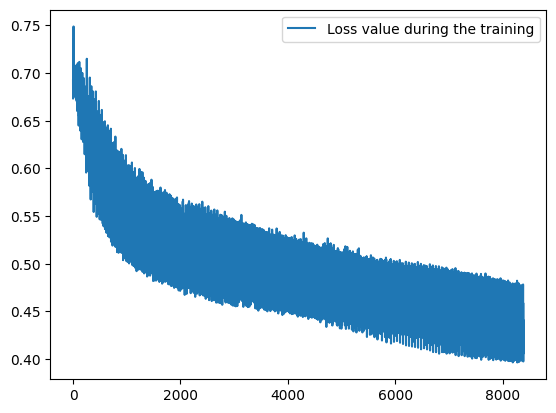

In [17]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

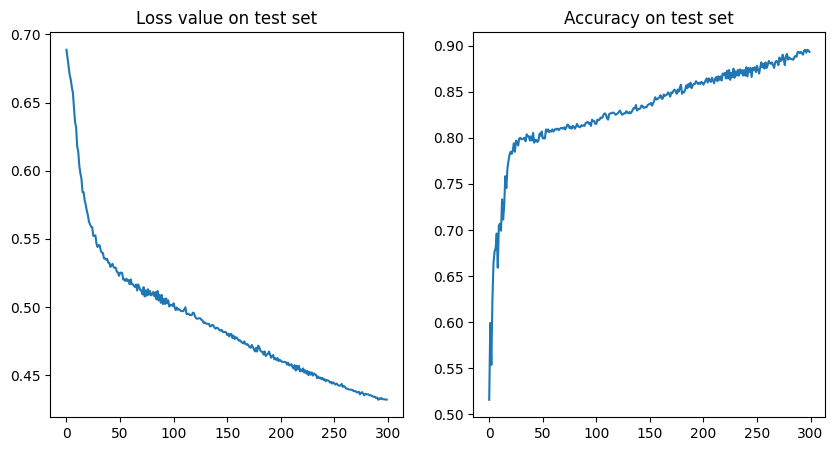

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Loss value on test set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on test set")
axs[1].plot(eval_metrics_history["test_accuracy"])

Our model reached almost 90% accuracy on the test set after 300 epochs, but it's worth noting
that the loss function isn't completely flat yet. We could continue until the curve flattens,
but we also need to pay attention to validation accuracy so as to spot when the model starts
overfitting.

For model early stopping and selecting best model, you can check out [Orbax](https://github.com/google/orbax),
a library which provides checkpointing and persistence utilities.